# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services



In this project, I will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. I will use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, I will use a model to predict which individuals are most likely to convert into becoming customers for the company. 

## Import libraries

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import random
import progressbar

from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('~/udacity-ds-project/bertelsmann_arvato_project/data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('~/udacity-ds-project/bertelsmann_arvato_project/data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
# Data shape
azdias.shape

(891221, 367)

In [5]:
# Data info
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 367 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 2.4+ GB


In [6]:
# Check object features
df_object = azdias.select_dtypes(include='object')
df_object.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## 1.1 Data Preparation 
### 1.1.1 Handle Missing Data 
Use the feature summary file and 'DIAS Attributes - Values 2017.xlsx' file to build a dataframe of columns properties in the demographics data.

In [7]:
# Load in the feature summary file.
feat_info = pd.read_csv('data/AZDIAS_Feature_Summary.csv', sep=';')
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
# feat_info shape
feat_info.shape

(85, 4)

In [9]:
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [10]:
# Laod DIAS Attributes
dias_attributes = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', skiprows=[0])
del dias_attributes['Unnamed: 0']

# Drop NaN attribute
dias_attributes = dias_attributes[~dias_attributes['Attribute'].isnull()]

# Drop attribute described in feat_info
dias_attributes = dias_attributes[~dias_attributes['Attribute'].isin(feat_info.attribute)]

dias_attributes.head()

,Attribute,Description,Value,Meaning
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known
152,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months


In [11]:
# dias_attributes shape
dias_attributes.shape

(233, 4)

In [12]:
# dias_attributes Meanning counts
dias_attributes.Meaning.value_counts(dropna=False)

unknown                                             172
no transaction known                                 34
highest activity within the last 12 months           12
no transactions known                                10
no Online-transactions within the last 12 months      3
Universal                                             1
very low car quote                                    1
Name: Meaning, dtype: int64

In [13]:
# Investigate attribute with unknown Meaning
unknown_Meaning = dias_attributes[dias_attributes['Meaning'] == 'unknown']

# Keep only attribute of azdias
unknown_Meaning = unknown_Meaning[
    unknown_Meaning['Attribute'].isin(azdias.columns)
]

# unknown_Meaning shape
unknown_Meaning.head()

,Attribute,Description,Value,Meaning
765,KBA05_ALTER1,share of car owners less than 31 years old,"-1, 9",unknown
771,KBA05_ALTER2,share of car owners inbetween 31 and 45 years ...,"-1, 9",unknown
777,KBA05_ALTER3,share of car owners inbetween 45 and 60 years ...,"-1, 9",unknown
783,KBA05_ALTER4,share of cars owners elder than 61 years,"-1, 9",unknown
790,KBA05_ANHANG,share of trailers in the microcell,"-1, 9",unknown


In [14]:
# Get first part of attribute
unknown_Meaning['first_att'] = unknown_Meaning.Attribute.apply(lambda x: x.split('_')[0])
unknown_Meaning.first_att.value_counts(dropna=False)

KBA13    106
KBA05     58
Name: first_att, dtype: int64

In [15]:
# Value of KBA05_ALTER1  
azdias.KBA05_ALTER1.value_counts(dropna=False)

2.0    228625
1.0    167046
3.0    166129
NaN    133324
0.0    102789
4.0     78522
9.0     14786
Name: KBA05_ALTER1, dtype: int64

In [16]:
# Values of KBA13_VORB_1  
azdias.KBA13_VORB_1.value_counts(dropna=False)

3.0    361449
2.0    167076
4.0    158150
NaN    105800
1.0     50939
5.0     47807
Name: KBA13_VORB_1, dtype: int64

In [17]:
# KBA13 and KBA05 are ordinals variabeles
unknown_Meaning['type'] = 'ordinal'
unknown_Meaning.head()

,Attribute,Description,Value,Meaning,first_att,type
765,KBA05_ALTER1,share of car owners less than 31 years old,"-1, 9",unknown,KBA05,ordinal
771,KBA05_ALTER2,share of car owners inbetween 31 and 45 years ...,"-1, 9",unknown,KBA05,ordinal
777,KBA05_ALTER3,share of car owners inbetween 45 and 60 years ...,"-1, 9",unknown,KBA05,ordinal
783,KBA05_ALTER4,share of cars owners elder than 61 years,"-1, 9",unknown,KBA05,ordinal
790,KBA05_ANHANG,share of trailers in the microcell,"-1, 9",unknown,KBA05,ordinal


In [18]:
# Investigate attribute with no transaction known
no_transaction = dias_attributes[dias_attributes['Meaning'].isin(['no transaction known',
                                                                  'no transactions known'])]

# Keep only attribute of azdias
no_transaction = no_transaction[no_transaction['Attribute'].isin(azdias.columns)]

# Get first part of attribute
no_transaction['first_att'] = no_transaction.Attribute.apply(lambda x: x.split('_')[0])

# unknown_Meaning shape
no_transaction

,Attribute,Description,Value,Meaning,first_att
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known,D19
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known,D19
305,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12...,0,no transactions known,D19
312,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,0,no transactions known,D19
478,D19_TELKO_ANZ_12,transaction activity TELCO in the last 12 months,0,no transactions known,D19
485,D19_TELKO_ANZ_24,transaction activity TELCO in the last 24 months,0,no transactions known,D19
546,D19_VERSAND_ANZ_12,transaction activity MAIL-ORDER in the last 12...,0,no transactions known,D19
553,D19_VERSAND_ANZ_24,transaction activity MAIL-ORDER in the last 24...,0,no transactions known,D19
617,D19_VERSI_ANZ_12,transaction activity INSURANCE in the last 12 ...,0,no transactions known,D19
624,D19_VERSI_ANZ_24,transaction activity INSURANCE in the last 24 ...,0,no transactions known,D19


In [19]:
# Values of D19_BANKEN_ANZ_12  
azdias.D19_BANKEN_ANZ_12.value_counts(dropna=False)

0    831734
1     29771
2     18067
3      5708
4      4082
5      1483
6       376
Name: D19_BANKEN_ANZ_12, dtype: int64

In [20]:
# D19 are ordinals variables
no_transaction['type'] = 'ordinal'
no_transaction.head()

,Attribute,Description,Value,Meaning,first_att,type
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known,D19,ordinal
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known,D19,ordinal
305,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12...,0,no transactions known,D19,ordinal
312,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,0,no transactions known,D19,ordinal
478,D19_TELKO_ANZ_12,transaction activity TELCO in the last 12 months,0,no transactions known,D19,ordinal


In [21]:
# Investigate the rest of attributes 
sub_dias = dias_attributes[~dias_attributes['Meaning'].isin(['no transaction known',
                                                             'no transactions known',
                                                            'unknown'])]

# Keep only attribute of azdias
sub_dias = sub_dias[sub_dias['Attribute'].isin(azdias.columns)]

# Get first part of attribute
sub_dias['first_att'] = sub_dias.Attribute.apply(lambda x: x.split('_')[0])

# unknown_Meaning shape
sub_dias

,Attribute,Description,Value,Meaning,first_att
152,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19
186,D19_BANKEN_OFFLINE_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19
196,D19_BANKEN_ONLINE_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19
206,D19_BANKEN_ONLINE_QUOTE_12,amount of online transactions within all trans...,0,no Online-transactions within the last 12 months,D19
319,D19_GESAMT_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months,D19
329,D19_GESAMT_OFFLINE_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months,D19
339,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months,D19
349,D19_GESAMT_ONLINE_QUOTE_12,amount of online transactions within all trans...,0,no Online-transactions within the last 12 months,D19
384,D19_KONSUMTYP,consumption type,1,Universal,D19
492,D19_TELKO_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19


In [22]:
# Values of D19_KONSUMTYP
azdias.D19_KONSUMTYP.value_counts(dropna=False)

NaN    257113
9.0    254296
1.0    117912
4.0     78262
6.0     56562
3.0     53330
2.0     49324
5.0     24422
Name: D19_KONSUMTYP, dtype: int64

In [23]:
# All attributes in sub_dias are ordinal except D19_KONSUMTYP which is categorical
sub_dias['type'] = sub_dias.Meaning.apply(
    lambda x: 'categorical' if x=='Universal' else 'ordinal')

# Make a dataframe of features proprieties
def_cl = lambda x: [str(k) for k in str(x).split(',')]
unknown_Meaning['missing_or_unknown'] = unknown_Meaning.Value.apply(def_cl)

# Drop colums
unknown_Meaning.drop(['Description', 'Value', 'Meaning', 'first_att'],
                    axis=1, inplace=True)

# Change columns name
unknown_Meaning.columns = ['attribute', 'type', 'missing_or_unknown']

unknown_Meaning.head()

,attribute,type,missing_or_unknown
765,KBA05_ALTER1,ordinal,"[-1, 9]"
771,KBA05_ALTER2,ordinal,"[-1, 9]"
777,KBA05_ALTER3,ordinal,"[-1, 9]"
783,KBA05_ALTER4,ordinal,"[-1, 9]"
790,KBA05_ANHANG,ordinal,"[-1, 9]"


In [24]:
# no_transaction
no_transaction['missing_or_unknown'] = no_transaction.Value.apply(lambda
                                                                 x: [str(x)])

# Drop colums
no_transaction.drop(['Description', 'Value', 'Meaning', 'first_att'],
                    axis=1, inplace=True)

# Change columns name
no_transaction.columns = ['attribute', 'type', 'missing_or_unknown']

no_transaction.head()

,attribute,type,missing_or_unknown
138,D19_BANKEN_ANZ_12,ordinal,[0]
145,D19_BANKEN_ANZ_24,ordinal,[0]
305,D19_GESAMT_ANZ_12,ordinal,[0]
312,D19_GESAMT_ANZ_24,ordinal,[0]
478,D19_TELKO_ANZ_12,ordinal,[0]


In [25]:
sub_dias['missing_or_unknown'] = sub_dias.Value.apply(lambda x: [])

# Drop colums
sub_dias.drop(['Description', 'Value', 'Meaning', 'first_att'],
              axis=1, inplace=True)

# Change columns name
sub_dias.columns = ['attribute', 'type', 'missing_or_unknown']

sub_dias.head()

,attribute,type,missing_or_unknown
152,D19_BANKEN_DATUM,ordinal,[]
186,D19_BANKEN_OFFLINE_DATUM,ordinal,[]
196,D19_BANKEN_ONLINE_DATUM,ordinal,[]
206,D19_BANKEN_ONLINE_QUOTE_12,ordinal,[]
319,D19_GESAMT_DATUM,ordinal,[]


In [26]:
# feat_info
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda 
                                                                        x: x[1:-1].split(','))

# Drop information_level 
feat_info.drop(['information_level'], axis=1, inplace=True)

feat_info.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [27]:
# Concat feat info
new_feat_info = pd.concat([feat_info, sub_dias, no_transaction,
                           unknown_Meaning], ignore_index=True)

# Shape of new_feat_info
new_feat_info.shape

(276, 3)

In [28]:
# Columns without type
col = azdias.columns[~azdias.columns.isin(new_feat_info.attribute)]

# Check object features
sub_object = azdias[col].select_dtypes(include='object')
sub_object.head()

,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM
0,NaN,NaN
1,NaN,1992-02-10 00:00:00
2,D19_UNBEKANNT,1992-02-12 00:00:00
3,D19_UNBEKANNT,1997-04-21 00:00:00
4,D19_SCHUHE,1992-02-12 00:00:00


In [29]:
sub_object.D19_LETZTER_KAUF_BRANCHE.value_counts(dropna=False)

NaN                       257113
D19_UNBEKANNT             195338
D19_VERSICHERUNGEN         57734
D19_SONSTIGE               44722
D19_VOLLSORTIMENT          34812
D19_SCHUHE                 32578
D19_BUCH_CD                28754
D19_VERSAND_REST           26034
D19_DROGERIEARTIKEL        24072
D19_BANKEN_DIREKT          23273
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20858
D19_TELKO_MOBILE           14447
D19_ENERGIE                12084
D19_TELKO_REST             11472
D19_BANKEN_GROSS           10550
D19_BEKLEIDUNG_GEH         10272
D19_KINDERARTIKEL           7301
D19_FREIZEIT                7257
D19_TECHNIK                 7002
D19_LEBENSMITTEL            6458
D19_BANKEN_REST             5247
D19_RATGEBER                4931
D19_NAHRUNGSERGAENZUNG      4061
D19_DIGIT_SERV              3577
D19_REISEN                  3122
D19_TIERARTIKEL             2578
D19_SAMMELARTIKEL           2443
D19_HANDWERK                2227
D19_WEIN_FEINKOST           2164
D19_GARTEN

In [30]:
describe = azdias[col].describe()
describe

,Unnamed: 0,LNR,AKT_DAT_KL,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,...,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11
count,891221.000000,8.912210e+05,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,817722.000000,798073.000000,...,793947.000000,793435.000000,793435.000000,817722.000000,793947.00000,817722.00000,770025.000000,815304.000000,815304.000000,815304.000000
mean,445610.000000,6.372630e+05,4.421928,11.745392,13.402658,14.476013,15.089627,13.700717,0.154018,7.599356,...,2.539212,3.223125,4.017526,0.090067,4.58576,0.43882,2.417322,6.001214,7.532130,5.945972
std,257273.486465,2.572735e+05,3.638805,4.097660,3.243300,2.712427,2.452932,5.079849,0.502389,14.332201,...,0.754926,1.255785,1.118399,0.286278,8.47152,1.14329,1.166572,2.856091,3.247789,2.771464
min,0.000000,1.916530e+05,1.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,1.000000
25%,222805.000000,4.144580e+05,1.000000,8.000000,11.000000,13.000000,14.000000,11.000000,0.000000,1.000000,...,2.000000,2.000000,3.000000,0.000000,0.00000,0.00000,2.000000,3.000000,5.000000,4.000000
50%,445610.000000,6.372630e+05,3.000000,12.000000,14.000000,15.000000,15.000000,14.000000,0.000000,3.000000,...,3.000000,3.000000,4.000000,0.000000,1.00000,0.00000,2.000000,6.000000,8.000000,6.000000
75%,668415.000000,8.600680e+05,9.000000,15.000000,16.000000,17.000000,17.000000,17.000000,0.000000,9.000000,...,3.000000,4.000000,5.000000,0.000000,5.00000,0.00000,3.000000,9.000000,10.000000,8.000000
max,891220.000000,1.082873e+06,9.000000,18.000000,18.000000,18.000000,18.000000,25.000000,11.000000,449.000000,...,3.000000,5.000000,5.000000,1.000000,45.00000,5.00000,4.000000,11.000000,13.000000,11.000000


In [31]:
# Data information
dias_info = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx',
                          skiprows=[0])
del dias_info['Unnamed: 0']
dias_info = dias_info[dias_info.Attribute.isin(col)]

dias_info

,Information level,Attribute,Description,Additional notes
67,NaN,D19_VERSI_OFFLINE_DATUM,actuality of the last transaction for the segm...,NaN
68,NaN,D19_VERSI_ONLINE_DATUM,actuality of the last transaction for the segm...,NaN
69,NaN,D19_VERSI_DATUM,actuality of the last transaction for the segm...,NaN


In [32]:
# List of columns to drop
col_to_drop = list(sub_object.columns)
col_to_drop

['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

In [33]:
# D19_LETZTER_KAUF_BRANCHE contains some variables names, and EINGEFUEGT_AM includes timestamps. 
# Therefore, I will drop them.
last_att_info = pd.DataFrame({'attribute': list(describe.columns)})
last_att_info['type'] = 'numeric'
last_att_info['missing_or_unknown'] = last_att_info['type'].apply(lambda x: [])

last_att_info.head()

,attribute,type,missing_or_unknown
0,Unnamed: 0,numeric,[]
1,LNR,numeric,[]
2,AKT_DAT_KL,numeric,[]
3,ALTER_KIND1,numeric,[]
4,ALTER_KIND2,numeric,[]


In [34]:
# Concat last_att_info and new_feat_info
new_feat_info = pd.concat([new_feat_info, last_att_info], ignore_index=True)
new_feat_info.shape

(365, 3)

Convert Missing Value Codes to NaNs

In [35]:
# Identify missing or unknown data values and convert them to NaNs.
for attrib, missing_values in zip(new_feat_info['attribute'],
                                  new_feat_info['missing_or_unknown']):
    if len(missing_values) != 0:
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan

# Drop col_to_drop
azdias.drop(col_to_drop, axis=1, inplace=True)

# check shape
azdias.shape

(891221, 365)

Assess Missing Data in Each Column

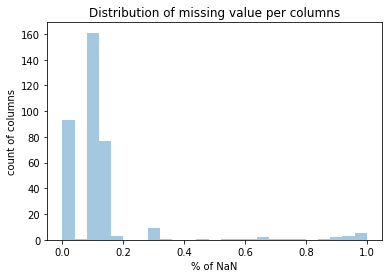

In [36]:
# Missing Data in Each Column
count_nan = azdias.isnull().sum()/len(azdias)

# Plot missing data in bar chart
plt.figure()
sns.distplot(count_nan.values, kde=False)
plt.ylabel('count of columns')
plt.xlabel('% of NaN')
plt.title('Distribution of missing value per columns')
plt.show()

In [37]:
# Most attributes contain less than 30% of missing values. 
# Therefore I will drop all features that include more than 30% of missing values.

# Get columns that have more than 30% of nan
more_30 = count_nan[count_nan > 0.3]
missing_col = list(more_30.index)
len(missing_col)

21

In [38]:
# Remove the outlier missing_col from the dataset.
azdias.drop(missing_col, axis=1, inplace=True)
azdias.shape

(891221, 344)

Assess Missing Data in Each Row

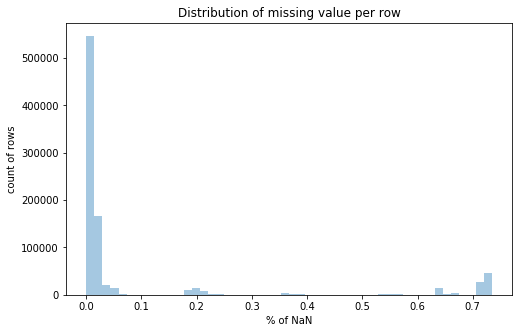

In [39]:
# Missing Data in Each Column
row_nan = azdias.isnull().sum(axis=1)

# Plot missing data in bar chart
fig = plt.figure(figsize=(8, 5))
sns.distplot(row_nan.values/343, kde=False)
plt.ylabel('count of rows')
plt.xlabel('% of NaN')
plt.title('Distribution of missing value per row')
plt.show()

In [40]:
fig.savefig('row_nan.png')

In [41]:
# Rows that contain many missing values are harmful to machine learning algorithms. 
# Therefore I will drop rows that contain more than 50% of missing values.

# Drop row that contains more than 50% of nan values
azdias = azdias.loc[row_nan[row_nan <= 0.5*343].index]
azdias.reset_index(drop=True, inplace=True)
azdias.shape

(791987, 344)

In [42]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791987 entries, 0 to 791986
Columns: 344 entries, Unnamed: 0 to ALTERSKATEGORIE_GROB
dtypes: float64(288), int64(52), object(4)
memory usage: 2.0+ GB


#### 1.1.2 Select and Re-Encode Features
Machine learning techniques work only on data that is encoded numerically, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. I will use the features description to re-encode features.
- I will keep numeric, ordinal and interval data without changes.
- Special handling is necessary for the remaining two variable types: categorical, and mixed.

In [43]:
new_feat_info.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [44]:
# keep only azdias attribute
final_feat_info = new_feat_info[new_feat_info.attribute.isin(azdias.columns)]

len(final_feat_info)

344

In [45]:
# How many features are there of each data type?
final_feat_info.type.value_counts(dropna=False)

ordinal        229
numeric         90
categorical     19
mixed            6
Name: type, dtype: int64

In [46]:
count_type = final_feat_info.type.value_counts(dropna=False)
df_count = pd.DataFrame(count_type.values, index=count_type.index, columns=['count columns'])
df_count

,count columns
ordinal,229
numeric,90
categorical,19
mixed,6


#### Re-Encode Categorical Features
For categorical data, depending on the number of categories, I will perform one of the following:
- For binary (two-level) categoricals that take numeric values, I will keep them without any change.
- For binary variables that take on non-numeric values, I will re-encod the values as numbers.
- For multi-level categoricals variables (three or more values), I will re-encod the values using multiple dummies variables.

In [47]:
final_feat_info.head()

,attribute,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]
5,FINANZ_SPARER,ordinal,[-1]


In [48]:
# Get list of Categorical Features
Cat_feat = list(final_feat_info.attribute[
        final_feat_info.type == 'categorical'])

binary_num_attribute = []
binary_str_attribute = []
multi_level_attribute = []

for att in Cat_feat:
    dtype = azdias[att].dtype
    count = len(azdias[att].value_counts())

    if count > 2:
        multi_level_attribute.append(att)
    else:
        if dtype == 'object':
            binary_str_attribute.append(att)
        else:
            binary_num_attribute.append(att)

In [49]:
# binary_num_attribute
binary_num_attribute

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

In [50]:
# binary_str_attribute
binary_str_attribute

['OST_WEST_KZ']

In [51]:
# multi_level_attribute
multi_level_attribute

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'D19_KONSUMTYP']

In [52]:
# Re-encode OST_WEST_KZ as dummy variable
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 1, 'O': 2})

# Convert cat to cat to dummies variables
def encode_cat(df, list_cat):
    list_df_dum = []
    for col_dum in list_cat:
        list_df_dum.append(pd.get_dummies(df[col_dum], prefix=col_dum))

    assert len(list_df_dum) == len(list_cat)
    
    # Drop cat col from df
    df.drop(list_cat, axis=1, inplace=True)
    list_df_dum.append(df)
    df = pd.concat(list_df_dum, axis=1)

    return df

new_azdias = encode_cat(azdias, multi_level_attribute)
new_azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,0,0,0,1,0,1,0,0,0,...,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,2.0,1.0
1,0,0,1,0,0,0,1,0,0,0,...,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,2.0,3.0
2,0,1,0,0,0,0,0,0,0,0,...,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,2.0,4.0
3,0,0,0,0,1,0,0,0,0,0,...,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,1.0,3.0
4,0,1,0,0,0,0,0,1,0,0,...,0.0,2.0,10.0,7.0,4.0,6.0,9.0,7.0,2.0,1.0


#### Engineer Mixed-Type Features
There are six mixed features. I will use the feature summary given in the previous project to encode them as ordinal and dummies variables.

In [53]:
mixed_att = list(final_feat_info.attribute[final_feat_info.type == 'mixed'])
mixed_att

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']


"PRAEGENDE_JUGENDJAHRE" Combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

In [54]:
# Map decade
dic_dec = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
           8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90,
           15: 90, np.nan: np.nan, -1: np.nan, 0: np.nan}

# Map mouvement
dic_mov = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
           9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,
           np.nan: np.nan, -1: np.nan, 0: np.nan}

new_azdias["PRAEGENDE_JUGENDJAHRE_dec"] = new_azdias["PRAEGENDE_JUGENDJAHRE"].map(dic_dec)

# Mainstream : 0, Avantgarde : 1
new_azdias["PRAEGENDE_JUGENDJAHRE_mov"] = new_azdias["PRAEGENDE_JUGENDJAHRE"].map(dic_mov)

# Drop PRAEGENDE_JUGENDJAHRE
new_azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

new_azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_dec,PRAEGENDE_JUGENDJAHRE_mov
0,0,0,0,0,1,0,1,0,0,0,...,8.0,11.0,10.0,3.0,9.0,4.0,2.0,1.0,90.0,0.0
1,0,0,1,0,0,0,1,0,0,0,...,9.0,9.0,6.0,3.0,9.0,2.0,2.0,3.0,90.0,1.0
2,0,1,0,0,0,0,0,0,0,0,...,7.0,10.0,11.0,NaN,9.0,7.0,2.0,4.0,70.0,0.0
3,0,0,0,0,1,0,0,0,0,0,...,3.0,5.0,4.0,2.0,9.0,3.0,1.0,3.0,70.0,0.0
4,0,1,0,0,0,0,0,1,0,0,...,10.0,7.0,4.0,6.0,9.0,7.0,2.0,1.0,50.0,0.0



"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. I will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.

In [55]:
def encode_CAMEO_INTL_2015(x):

    if np.isnan(x):
        return [np.nan, np.nan]
    else:
        x = str(x).split('.')[0]
        return [int(x[0]), int(x[1])]


new_azdias["CAMEO_INTL_2015"] = new_azdias["CAMEO_INTL_2015"].astype('float')
new_azdias["CAMEO_INTL_2015"] = new_azdias["CAMEO_INTL_2015"].apply(encode_CAMEO_INTL_2015)

# CAMEO_INTL_2015_wealth
new_azdias["CAMEO_INTL_2015_wealth"] = new_azdias["CAMEO_INTL_2015"].apply(lambda x: x[0])

# CAMEO_INTL_2015_life_stage
new_azdias["CAMEO_INTL_2015_life_stage"] = new_azdias["CAMEO_INTL_2015"].apply(lambda x: x[1])

# drop CAMEO_INTL_2015
new_azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

new_azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_dec,PRAEGENDE_JUGENDJAHRE_mov,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
0,0,0,0,0,1,0,1,0,0,0,...,10.0,3.0,9.0,4.0,2.0,1.0,90.0,0.0,5.0,1.0
1,0,0,1,0,0,0,1,0,0,0,...,6.0,3.0,9.0,2.0,2.0,3.0,90.0,1.0,2.0,4.0
2,0,1,0,0,0,0,0,0,0,0,...,11.0,NaN,9.0,7.0,2.0,4.0,70.0,0.0,1.0,2.0
3,0,0,0,0,1,0,0,0,0,0,...,4.0,2.0,9.0,3.0,1.0,3.0,70.0,0.0,4.0,3.0
4,0,1,0,0,0,0,0,1,0,0,...,4.0,6.0,9.0,7.0,2.0,1.0,50.0,0.0,5.0,4.0



"LP_LEBENSPHASE_FEIN" contains information about life stage and fine scale. I will create two new ordinals features, one for life_stage and other for fine_scale

In [56]:
life_stage = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

fine_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}

new_azdias['LP_life_stage'] = new_azdias['LP_LEBENSPHASE_FEIN'].map(life_stage)
new_azdias['LP_fine_scale'] = new_azdias['LP_LEBENSPHASE_FEIN'].map(fine_scale)

# Drop LP_LEBENSPHASE_FEIN
new_azdias.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

# R-encode LP_life_stage and LP_fine_scale as ordinal
dic_life = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
dic_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}

new_azdias['LP_life_stage'] = new_azdias['LP_life_stage'].map(dic_life)
new_azdias['LP_fine_scale'] = new_azdias['LP_fine_scale'].map(dic_scale)

new_azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNDAUER_2008,WOHNLAGE,ANREDE_KZ,ALTERSKATEGORIE_GROB,PRAEGENDE_JUGENDJAHRE_dec,PRAEGENDE_JUGENDJAHRE_mov,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage,LP_life_stage,LP_fine_scale
0,0,0,0,0,1,0,1,0,0,0,...,9.0,4.0,2.0,1.0,90.0,0.0,5.0,1.0,2.0,1.0
1,0,0,1,0,0,0,1,0,0,0,...,9.0,2.0,2.0,3.0,90.0,1.0,2.0,4.0,1.0,2.0
2,0,1,0,0,0,0,0,0,0,0,...,9.0,7.0,2.0,4.0,70.0,0.0,1.0,2.0,NaN,NaN
3,0,0,0,0,1,0,0,0,0,0,...,9.0,3.0,1.0,3.0,70.0,0.0,4.0,3.0,3.0,2.0
4,0,1,0,0,0,0,0,1,0,0,...,9.0,7.0,2.0,1.0,50.0,0.0,5.0,4.0,4.0,2.0


LP_LEBENSPHASE_GROB contains the same information as LP_LEBENSPHASE_FEIN. Therefore I will drop it.

In [57]:
new_azdias.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)

Re-encode PLZ8_BAUMAX as dummies variables

In [58]:
# replace 0 by nan
new_azdias['WOHNLAGE'] = new_azdias['WOHNLAGE'].replace(0, np.nan)

# Get dummumies variable
WOHNLAGE = pd.get_dummies(new_azdias['WOHNLAGE'], prefix='WOHNLAGE')

# Drop WOHNLAGE
new_azdias.drop('WOHNLAGE', axis=1, inplace=True)

# concat WOHNLAGE with new_azdias
new_azdias = pd.concat([new_azdias, WOHNLAGE], axis=1)

Re-encode PLZ8_BAUMAX as dummies variables

In [59]:
# Get dummumies variable
PLZ8_BAUMAX = pd.get_dummies(new_azdias['PLZ8_BAUMAX'], prefix='PLZ8_BAUMAX')

# Drop PLZ8_BAUMAX
new_azdias.drop('PLZ8_BAUMAX', axis=1, inplace=True)

# concat PLZ8_BAUMAX with new_azdias
new_azdias = pd.concat([new_azdias, PLZ8_BAUMAX], axis=1)
new_azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0


### 1.1.3 Create a Cleaning Function

In [60]:
def clean_data(df, drop_col=True, drop_row=True):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Drop 'D19_LETZTER_KAUF_BRANCHE' and 'EINGEFUEGT_AM'
    df.drop(col_to_drop, axis=1, inplace=True)

    # convert missing value codes into NaNs
    for attrib, missing_values in zip(new_feat_info['attribute'],
                                      new_feat_info['missing_or_unknown']):
        if len(missing_values) != 0:
            for value in missing_values:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                df.loc[df[attrib] == value, attrib] = np.nan

    # remove selected columns
    if drop_col:
        df.drop(missing_col, axis=1, inplace=True)
    
    # assessing missing value per row
    row_nan = df.isnull().sum(axis=1)
    a = df.shape[1]
    
    if drop_row:
        df = df.loc[row_nan[row_nan<=0.5*a].index]
        df.reset_index(drop=True, inplace=True)

    # Re-encode OST_WEST_KZ as dummy variable
    df['OST_WEST_KZ'] =  df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    
    # Convert cat to cat to dummies variables
    df = encode_cat(df, multi_level_attribute)
    
    # Mix
    df["PRAEGENDE_JUGENDJAHRE_dec"] = df["PRAEGENDE_JUGENDJAHRE"].map(dic_dec)

    # Mainstream : 0, Avantgarde : 1
    df["PRAEGENDE_JUGENDJAHRE_mov"] = df["PRAEGENDE_JUGENDJAHRE"].map(dic_mov)

    # Drop PRAEGENDE_JUGENDJAHRE
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # re
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].astype('float')
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].apply(encode_CAMEO_INTL_2015)

    # CAMEO_INTL_2015_wealth
    df["CAMEO_INTL_2015_wealth"] = df["CAMEO_INTL_2015"].apply(lambda x: x[0])

    # CAMEO_INTL_2015_life_stage
    df["CAMEO_INTL_2015_life_stage"] = df["CAMEO_INTL_2015"].apply(lambda x: x[1])

    # drop CAMEO_INTL_2015
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    #
    df['LP_life_stage'] = df['LP_LEBENSPHASE_FEIN'].map(life_stage)
    df['LP_fine_scale'] = df['LP_LEBENSPHASE_FEIN'].map(fine_scale)

    # Drop LP_LEBENSPHASE_FEIN 
    df.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    
    df['LP_life_stage'] = df['LP_life_stage'].map(dic_life)
    df['LP_fine_scale'] = df['LP_fine_scale'].map(dic_scale)
    
    # Drop LP_LEBENSPHASE_GROB
    df.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    
    # replace 0 by nan
    df['WOHNLAGE'] = df['WOHNLAGE'].replace(0, np.nan)

    # Get dummumies variable
    WOHNLAGE = pd.get_dummies(df['WOHNLAGE'], prefix='WOHNLAGE')

    # Drop WOHNLAGE
    df.drop('WOHNLAGE', axis=1, inplace=True)

    # concat WOHNLAGE with new_azdias
    df = pd.concat([df, WOHNLAGE], axis=1)
    
    # Get dummumies variable
    PLZ8_BAUMAX = pd.get_dummies(df['PLZ8_BAUMAX'], prefix='PLZ8_BAUMAX')

    # Drop PLZ8_BAUMAX
    df.drop('PLZ8_BAUMAX', axis=1, inplace=True)

    # concat PLZ8_BAUMAX with new_azdias
    df = pd.concat([df, PLZ8_BAUMAX], axis=1)
    
    return df

In [61]:
new_azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0


## 1.2 Feature Transformation
### 1.2.1: Apply Feature Scaling
LNR is not useful for machine learning because it contains a unique value for each row. Therefore, I will drop it.

In [62]:
# drop LNR from data to process
LNR_azdias = new_azdias['LNR']
new_azdias.drop('LNR', axis=1, inplace=True)

In [63]:
# Imputer
Imp = SimpleImputer(missing_values=np.nan, strategy='median')
new_azdias = pd.DataFrame(Imp.fit_transform(new_azdias.values),
                          columns=new_azdias.columns)

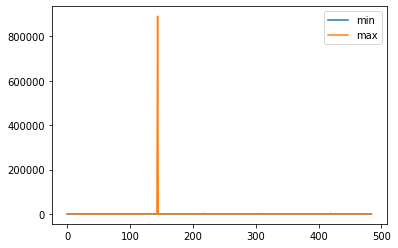

In [64]:
# Check features range
describe_azdias = new_azdias.describe()
plt.figure()
plt.plot(describe_azdias.loc['min'].values, label='min')
plt.plot(describe_azdias.loc['max'].values, label='max')
plt.legend()
plt.show()

Somme features have a big range. I will scale the data to avoid that some feature imbalance weight

In [65]:
# Apply feature scaling to the general population demographics data.
scaler = RobustScaler()
scaled_azdias = pd.DataFrame(scaler.fit_transform(new_azdias.values),
                          columns=new_azdias.columns)

scaled_azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.2.2 Perform Dimensionality Reduction
I will use sklearn's PCA class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data.

In [66]:
# Apply PCA to the azdias data.
pca = PCA()
azdias_pca = pca.fit_transform(scaled_azdias)                                                                                                                   

In [67]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]),
                    va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

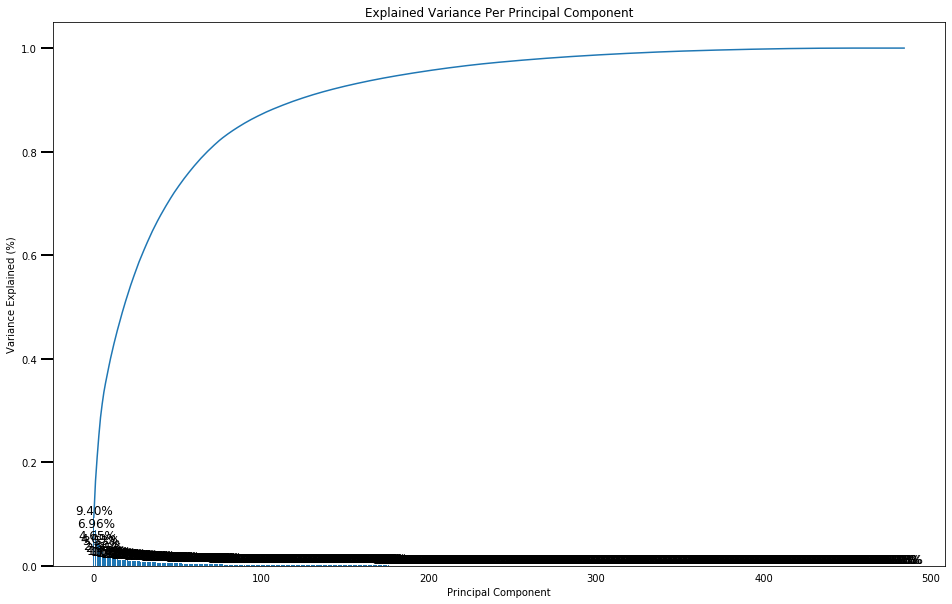

In [68]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [69]:
# Re-apply PCA to the data whith 200 components.
pca = PCA(n_components=200)
azdias_pca = pca.fit_transform(scaled_azdias)

Looking at the plot above, we may notice that after 200 components the cumulative explained variance becomes superior to 0.95. So I will choose 200 features to re-do the PCA.
## 1.3 Clustering
### 1.3.1: Apply Clustering to General Population
I will use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data.


In [70]:
# Compute the average within-cluster distances.
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # instantiate kmeans
    kmeans = KMeans(n_clusters=center, random_state=42, n_jobs=-1)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [71]:
# Apply the elbow method
score_list = []
centers = np.arange(2, 15, 1)

for center in centers: 
    # Append score to 
    score_list.append(get_kmeans_score(azdias_pca, center))

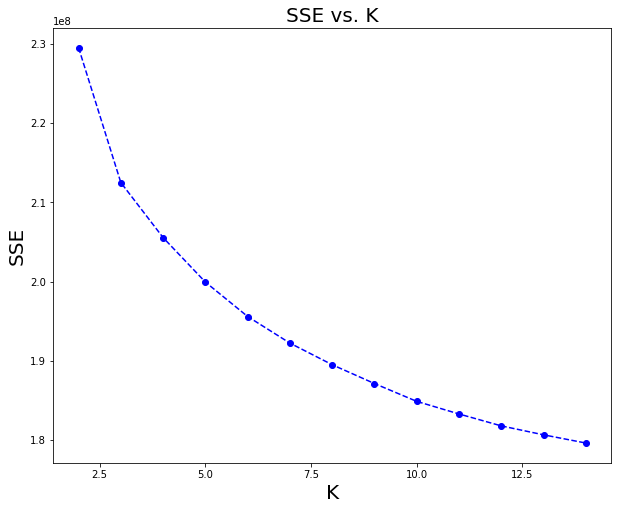

In [72]:
# Investigate the change in within-cluster distance across number of clusters.

plt.figure(figsize=(10, 8)) 
plt.plot(centers, score_list, linestyle='--', marker='o', color='b');
matplotlib.rc('xtick', labelsize=30)  
matplotlib.rc('ytick', labelsize=30)
plt.xlabel('K', fontsize=20)
plt.ylabel('SSE', fontsize=20)
plt.title('SSE vs. K', fontsize=20)
plt.show()

Looking at the plot above, we can notice that the score keeps decreasing and there is no visible elbow, but after 6 clusters the decrease is weaker. I will choose six clusters to do KMeans clustering.

In [73]:
# Re-fit the k-means model with 6 class
kmeans = KMeans(n_clusters=6, random_state=42, n_jobs=-1)
labels_azdias = kmeans.fit_predict(azdias_pca)

In [74]:
class_count = pd.Series(labels_azdias).value_counts()

cls_azdias = pd.DataFrame({'cluster': class_count.index,
                           '% of data': 100*class_count.values/len(labels_azdias)})
cls_azdias['data'] = 'general population'

# print cls_azdias
cls_azdias

,cluster,% of data,data
0,4,37.441019,general population
1,3,31.246978,general population
2,1,19.146526,general population
3,5,5.323320,general population
4,2,4.975208,general population
5,0,1.866950,general population


### 1.3.2 Apply All Steps to the Customer Data

In [75]:
# Load in the customer demographics data.
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')
customers.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [76]:
# clean customer demographics data.
new_customers = clean_data(customers)
new_customers.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [77]:
# Remove additional columns
sub_customers = new_customers[['LNR', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                               'PRODUCT_GROUP']]

new_customers.drop(['LNR', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                    'PRODUCT_GROUP'], axis=1, inplace=True)

In [78]:
print('new_azdias shape', new_azdias.shape)
print('new_customers shape', new_customers.shape)

new_azdias shape (791987, 485)
new_customers shape (140899, 484)


In [79]:
#  Check for missing column in `new_customers`
mask = new_azdias.columns.isin(new_customers.columns)
miss_att = list(new_azdias.columns[~mask])
miss_att

['GEBAEUDETYP_5.0']

In [80]:
# Add the missing column with default value of 0
new_customers['GEBAEUDETYP_5.0'] = 0
new_customers['GEBAEUDETYP_5.0'] = new_customers['GEBAEUDETYP_5.0'].astype('uint8')

In [81]:
# replace missing value
new_customers = pd.DataFrame(Imp.fit_transform(new_customers.values),
                          columns=new_customers.columns)

# scale customers variables
new_customers = pd.DataFrame(scaler.fit_transform(new_customers.values),
                         columns=new_customers.columns)

In [82]:
# cluster predictions for the  customer demographics data.
customers_pca = pca.fit_transform(new_customers)
labels_customers = kmeans.predict(customers_pca)

In [83]:
cus_class = pd.Series(labels_customers).value_counts()

cls_customers = pd.DataFrame({'cluster': cus_class.index,
                              '% of data': 100*cus_class.values/len(labels_customers)})
cls_customers['data'] = 'customers data'

# print cls_azdias
cls_customers

,cluster,% of data,data
0,4,45.523389,customers data
1,3,40.741240,customers data
2,1,7.816237,customers data
3,2,4.294566,customers data
4,5,1.499656,customers data
5,0,0.124912,customers data


### 1.3.3 Compare Customer Data to Demographics Data

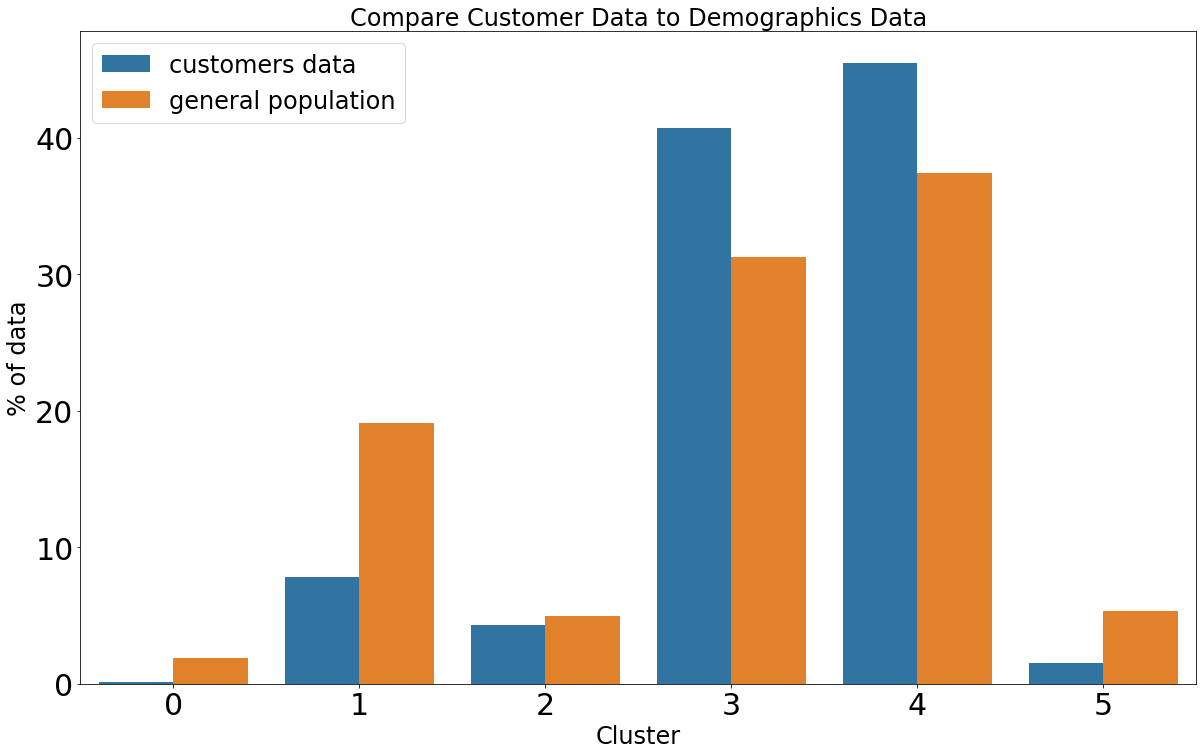

In [84]:
plt.figure(figsize=(20, 12))
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([cls_customers, cls_azdias]))
plt.xlabel('Cluster', fontsize=24)
plt.ylabel('% of data', fontsize=24)
plt.title('Compare Customer Data to Demographics Data', fontsize=24)
plt.legend(fontsize=24)
plt.show()

In [85]:
# Select people in the target class
target_class = [1]
target_pca = pca.inverse_transform(azdias_pca[np.isin(labels_azdias, target_class)])
target_azdias = scaler.inverse_transform(target_pca).round()
target_azdias = pd.DataFrame(target_azdias, columns=new_azdias.columns)
 
target_azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,1.0,0.0,0.0,...,-0.0,-0.0,1.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0
2,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,...,0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,...,0.0,-0.0,0.0,0.0,1.0,0.0,-0.0,-0.0,0.0,0.0
4,-0.0,1.0,0.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,...,0.0,-0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,0.0


In [86]:
# Select peaple in the no target class
no_target_class = [0, 2, 3, 4, 5]
no_target_pca = pca.inverse_transform(azdias_pca[np.isin(labels_azdias, no_target_class)])
no_target_azdias = scaler.inverse_transform(no_target_pca).round()
no_target_pca = pd.DataFrame(no_target_pca, columns=new_azdias.columns)

# Get LNR variable
no_target_LNR = LNR_azdias[np.isin(labels_azdias, no_target_class)]
no_target_pca['LNR'] = no_target_LNR.values 
 
no_target_pca.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,LNR
0,0.094973,0.063834,0.133390,0.423468,0.289844,-0.013775,0.167046,0.551748,0.048775,0.058431,...,0.062338,-0.320932,0.021674,-0.560275,0.161935,0.037525,0.103320,0.231951,0.0,910220
1,0.377565,0.021190,0.099980,0.201005,0.189475,0.156820,0.008288,0.479907,0.060628,0.010075,...,0.043731,0.210331,0.025093,-0.443023,0.146991,0.060607,0.106538,0.113386,0.0,910225
2,0.334530,0.025367,0.326135,0.241861,-0.011116,-0.000098,0.055926,0.270218,0.087159,0.025207,...,0.081960,0.481373,0.071519,-0.608426,0.049462,0.043173,0.149229,0.340747,0.0,910226
3,0.388043,0.574589,0.106549,-0.266000,-0.135649,0.250837,-0.049099,-0.362899,-0.082362,0.000538,...,0.097517,-0.649818,-0.082948,-0.425717,-0.028812,0.111284,0.194814,0.184358,0.0,910241
4,0.232409,0.590990,0.116164,-0.036763,-0.086585,0.117886,0.014015,0.100367,0.004672,-0.000349,...,0.038227,-0.237191,0.002589,-0.545045,0.193197,0.152474,0.029098,0.141750,0.0,910244


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

## 2.1 Exploring the Data 

In [87]:
mailout_train = pd.read_csv('~/udacity-ds-project/bertelsmann_arvato_project/data/Udacity_MAILOUT_052018_TRAIN.csv',
                            sep=';')

mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [88]:
# Data shape
mailout_train.shape

(42962, 368)

In [89]:
# Response values
cout = mailout_train.RESPONSE.value_counts(dropna=False)
df_sp = pd.DataFrame({'RESPONSE': cout.index, '% of data': cout.values})
df_sp['% of data'] = 100*df_sp['% of data']/42962

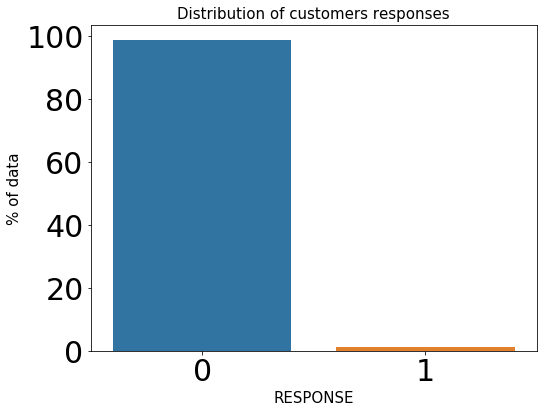

In [90]:
plt.figure(figsize=(8, 6))
sns.barplot(x="RESPONSE", y="% of data", data=df_sp)
matplotlib.rc('xtick', labelsize=25)  
matplotlib.rc('ytick', labelsize=25)
plt.xlabel('RESPONSE', fontsize=15)
plt.ylabel('% of data', fontsize=15)
plt.title('Distribution of customers responses', fontsize=15)
plt.show()

Out of all the 42 962 individuals in the mailout campaign, only 532 of the individuals became customers. The dataset is highly imbalanced.
## 2.2 Preparing the Data

In [91]:
# Cleaning data
clean_mailout = clean_data(mailout_train)

In [92]:
# Response values
clean_mailout.RESPONSE.value_counts(dropna=False)

0    34663
1      437
Name: RESPONSE, dtype: int64

In [93]:
# Cheking missing values
sum_null = clean_mailout.isnull().sum(axis=1)

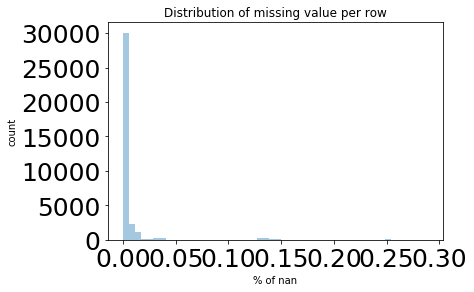

In [94]:
plt.figure()
sns.distplot(sum_null.values/485, kde=False)
plt.ylabel('count')
plt.xlabel('% of nan')
plt.title('Distribution of missing value per row')
matplotlib.rc('xtick', labelsize=10)  
matplotlib.rc('ytick', labelsize=10)
plt.show()

In [95]:
# Get LNR variable
mailout_LNR = clean_mailout['LNR'] 

# Drop LNR 
clean_mailout.drop('LNR', axis=1, inplace=True)

In [96]:
# Imputer
new_mailout = pd.DataFrame(Imp.fit_transform(clean_mailout.values),
                          columns=clean_mailout.columns)

In [97]:
# feature scaling
new_mailout = pd.DataFrame(scaler.fit_transform(new_mailout.values),
                          columns=new_mailout.columns)

In [98]:
# split data to features and labels
response = new_mailout['RESPONSE']

# drop RESPONSE variable
features = new_mailout.drop('RESPONSE', axis=1)

## 3.3 Modeling the data
**Evaluating Model Performance** 

Since the data is highly imbalanced, using accuracy as a metric to evaluate model performance will give us a misleading result. Instead, I will use ROC-AUC to assess models performances.

**Supervised Learning Models**

Ensemble methods have become some of the most popular methods used to compete in competitions on Kaggle and used in industry across applications because of their ability to optimize both variance and bias. Therefore in this project, I will test the following three ensemble algorithms:
- RandomForestRegressor
- XGBRegressor

In [99]:
# Initialize the three models
model_A = XGBRegressor(objective='binary:logistic', random_state=42)
model_B = RandomForestRegressor(random_state=42)

In [100]:
# randomize the data
def randomize(X, Y):
    permutation = np.random.permutation(Y.shape[0])
    X2 = X[permutation, :]
    Y2 = Y[permutation]
    
    return X2, Y2


X_train, y_train = randomize(np.asarray(features), np.asarray(response))

In [101]:
# Learning Curves
def draw_learning_curves(X, y, estimator, title="Learning Curves"):
    
    X2, y2 = randomize(X, y)
    
    train_sizes = np.linspace(.1, 1.0, 10)
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X2,
                                                            y2,
                                                            cv=5,
                                                            scoring='roc_auc',
                                                            n_jobs=-1,
                                                            train_sizes=train_sizes,
                                                            shuffle=True,
                                                            verbose=10
                                                           )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    fig = plt.figure()
    plt.grid()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Auc score")

    plt.plot(train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(test_scores_mean, 'o-', color="y",
             label="Cross-validation score")

    plt.legend(loc="best")

    plt.show()

[learning_curve] Training set sizes: [ 2808  5616  8424 11232 14040 16848 19656 22464 25272 28080]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:   47.4s remaining: 12.4min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:  1.8min remaining:  8.0min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:  2.8min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:  4.0min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:  5.0min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  6.4min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:  7.3min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  8.4min remaining:   55.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.2min finished


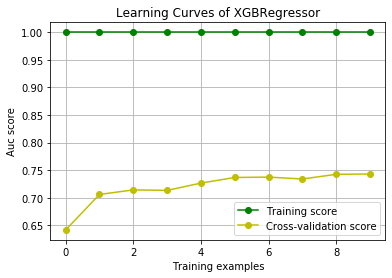

In [102]:
# XGBCRegressor
draw_learning_curves(X_train, y_train, model_A,
                     title="Learning Curves of XGBRegressor")

[learning_curve] Training set sizes: [ 2808  5616  8424 11232 14040 16848 19656 22464 25272 28080]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed:  2.0min remaining: 30.6min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:  5.5min remaining: 25.0min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed: 11.3min remaining: 26.4min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed: 15.4min remaining: 21.3min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed: 19.8min remaining: 16.9min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 24.7min remaining: 12.7min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 28.9min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 34.2min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 38.2min finished


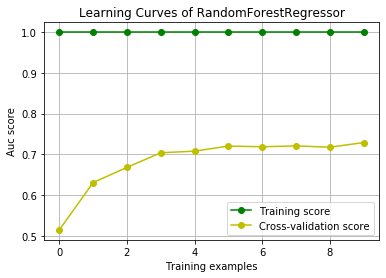

In [103]:
# RandomForestRegressor
draw_learning_curves(X_train, y_train, model_B,
                     title="Learning Curves of RandomForestRegressor")

**Discusion**

For XGBRegressor, the training score keeps decreasing, and the testing score keeps increasing. While for the RandomForestRegressor, the training score remains constant at a high level and the cross-validation score is low. It is clear that the best model is XGBRegressor because the RandomForestRegressor overfits the data.

## 2.4 Parameter Tuning

Approach for Parameter Tuning :
- Choose a relatively high learning rate. Generally, a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. 
- Determine the optimum number of trees for this learning rate. XGBoost has a handy function called “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
- Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and the number of trees.
- Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
- Lower the learning rate and decide the optimal parameters.

In [104]:
# function for modeling and cross-validation
def modelval(alg, X_train, y_train, useTrainCV=True,
             cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain,
                          num_boost_round=alg.get_params()[
                              'n_estimators'], nfold=cv_folds,
                          metrics='auc', verbose_eval=20,
                          early_stopping_rounds=early_stopping_rounds,
                          shuffle=True)
        
        alg.set_params(n_estimators=cvresult.shape[0])
        
        print('n_estimators=', cvresult.shape[0])
        
    # cross-validation
    all_auc = cross_val_score(alg, X_train, y_train,
                              scoring='roc_auc', cv=5,
                              n_jobs=-1, verbose=10
                             )
    
    auc = np.average(all_auc)
    print("AUC Score : %f" % auc)

### 2.4.1 Find the number of estimators

In [105]:
xgb1 = XGBRegressor(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27,
        random_state=42)

modelval(xgb1, X_train, y_train)

[0]	train-auc:0.76305+0.00275	test-auc:0.75789+0.02109
[20]	train-auc:0.85602+0.00605	test-auc:0.77549+0.01740
[40]	train-auc:0.92855+0.00307	test-auc:0.78261+0.01830
[60]	train-auc:0.97213+0.00198	test-auc:0.78215+0.01573
[80]	train-auc:0.99271+0.00192	test-auc:0.78113+0.02345
n_estimators= 39
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.6s remaining:   38.4s
AUC Score : 0.770727
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   25.8s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.0s finished


### 2.4.2 Tune max_depth and min_child_weight

In [106]:
# Grid seach on subsample and max_features
param_test1 = {
    'max_depth':range(3,10,1),
    'min_child_weight':range(1,6,1)
}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=13,
                                                  max_depth=5, min_child_weight=1, gamma=0,
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective='binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test1, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  4

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    gamma=0, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=13, n_j...
                                    objective='binary:logistic',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=1,
                                    seed=27, subsample=0.8, tree_method=None,
    

In [107]:
gsearch1.best_score_, gsearch1.best_params_

(0.7769470748868694, {'max_depth': 3, 'min_child_weight': 5})

In [108]:
param_test2 = {
 'max_depth':[2,3],
}

gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=13,
                                                  max_depth=3, min_child_weight=5, gamma=0,
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective='binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test2, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)
gsearch2.fit(X_train,y_train)

print('Best score: ', gsearch2.best_score_)
print('Best params: ', gsearch2.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    7.3s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    7.4s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    8.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.5s finished
Best score:  0.7769470748868694
Best params:  {'max_depth': 3}


### 2.4.3 Tune gamma

In [109]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=13,
                                                  max_depth=3, min_child_weight=5, gamma=0,
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective='binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test3, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)
gsearch3.fit(X_train,y_train)

print('Best score: ', gsearch3.best_score_)
print('Best params: ', gsearch3.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:   18.2s remaining:   16.8s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   18.2s remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   27.0s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   27.3s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   28.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   28.8s finished
Best score:  0.7775391787645066
Best params:  {'gamma': 0.4}


### 2.4.4 re-calibrate the number of boosting rounds for the updated parameters

In [110]:
xgb2 = XGBRegressor(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=3,
        min_child_weight=5,
        gamma=0.4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27,
        random_state=42)

modelval(xgb2, X_train, y_train)

[0]	train-auc:0.76178+0.00233	test-auc:0.75806+0.02114
[20]	train-auc:0.80910+0.00553	test-auc:0.78498+0.01853
[40]	train-auc:0.84799+0.00332	test-auc:0.77974+0.01499
[60]	train-auc:0.87398+0.00426	test-auc:0.78172+0.01354
n_estimators= 20
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
AUC Score : 0.774605
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    8.7s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


### 2.4.5 Tune subsample and colsample_bytree

In [111]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=45,
                                                  max_depth=3, min_child_weight=5, gamma=0.4,
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective='binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test4, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)
gsearch4.fit(X_train,y_train)

print('Best score: ', gsearch4.best_score_)
print('Best params: ', gsearch4.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:  4.6min remaining:   22.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  4.7min finished
Best score:  0.7789342514928345
Best params:  {'colsample_bytree': 0.6, 'subsample': 0.6}


In [112]:
param_test5 = {
 'subsample':[i/100.0 for i in range(40, 70,5)],
 'colsample_bytree':[i/100.0 for i in range(40,70,5)]
}

gsearch5 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, n_estimators=45,
                                                  max_depth=3, min_child_weight=5, gamma=0.4,
                                                  subsample=0.6, colsample_bytree=0.6,
                                                  objective='binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test5, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)
gsearch5.fit(X_train,y_train)

print('Best score: ', gsearch5.best_score_)
print('Best params: ', gsearch5.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  6

### 2.4.6 Tuning Regularization Parameters


In [113]:
param_test6 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

gsearch6 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=45,
                                                  max_depth=3, min_child_weight=5, gamma=0.4,
                                                  subsample=0.45, colsample_bytree=0.5,
                                                  objective='binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test6, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)
gsearch6.fit(X_train,y_train)

print('Best score: ', gsearch6.best_score_)
print('Best params: ', gsearch6.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:   37.1s remaining:   34.2s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:   37.3s remaining:   21.0s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   50.0s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:   52.5s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   54.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   54.3s finished
Best score:  0.7807062910762411
Best params:  {'reg_alpha': 1e-05}


In [114]:
xgb3 = XGBRegressor(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=3,
        min_child_weight=5,
        gamma=0.4,
        subsample=0.45,
        colsample_bytree=0.5,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27,
        random_state=42)

modelval(xgb3, X_train, y_train)

[0]	train-auc:0.50000+0.00000	test-auc:0.50000+0.00000
[20]	train-auc:0.81286+0.00804	test-auc:0.78803+0.01270
[40]	train-auc:0.84407+0.00661	test-auc:0.78784+0.02111
[60]	train-auc:0.86880+0.00477	test-auc:0.78622+0.01960
[80]	train-auc:0.89115+0.00252	test-auc:0.78057+0.01329
n_estimators= 35
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
AUC Score : 0.780931
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.5s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.5s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished


### 2.4.7 Reducing Learning Rate

In [115]:
param_test7 = {
 'learning_rate':[0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}

gsearch7 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=52,
                                                  max_depth=3, min_child_weight=5, gamma=0.4,
                                                  subsample=0.45, colsample_bytree=0.5,
                                                  objective='binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test7, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)
gsearch7.fit(X_train,y_train)

print('Best score: ', gsearch7.best_score_)
print('Best params: ', gsearch7.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.1min remaining:   37.8s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.1min remaining:   20.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.4min remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished
Best score:  0.7845467886671915
Best params:  {'learning_rate': 0.08}


In [116]:
# final model
model = XGBRegressor(
        learning_rate=0.08,
        n_estimators=52,
        max_depth=3,
        min_child_weight=5,
        gamma=0.4,
        subsample=0.45,
        colsample_bytree=0.5,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27,
        random_state=42)

# train the model
model.fit(X_train, y_train, eval_metric='auc')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=3,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=52, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='binary:logistic', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.45,
             tree_method='exact', validate_parameters=1, verbosity=None)

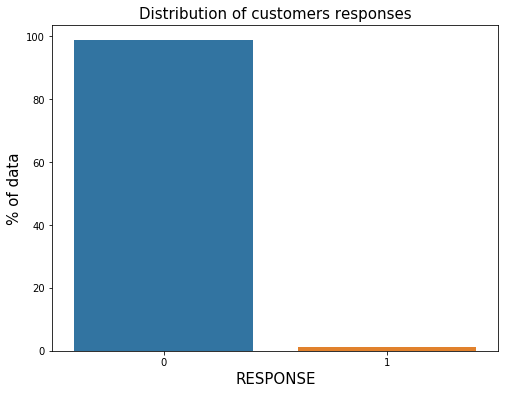

In [117]:
plt.figure(figsize=(8, 6))
sns.barplot(x="RESPONSE", y="% of data", data=df_sp)
matplotlib.rc('xtick', labelsize=25)  
matplotlib.rc('ytick', labelsize=25)
plt.xlabel('RESPONSE', fontsize=15)
plt.ylabel('% of data', fontsize=15)
plt.title('Distribution of customers responses', fontsize=15)
plt.show()

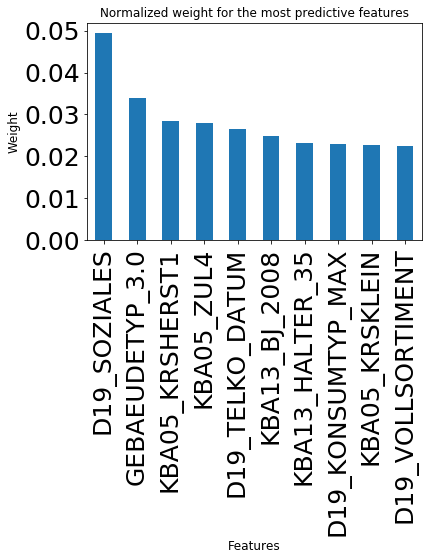

In [118]:
# feature importance
feat_imp = pd.Series(model.feature_importances_,
                     index=features.columns).sort_values(ascending=False)
# plot 20 important features
fig = plt.figure()
feat_imp.iloc[:10].plot(kind='bar') #, title='Feature Importances')
matplotlib.rc('xtick', labelsize=12)  
matplotlib.rc('ytick', labelsize=12)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Weight', fontsize=12)
plt.title('Normalized weight for the most predictive features', fontsize=12)
plt.show()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [119]:
# Load data
mailout_test = pd.read_csv('~/udacity-ds-project/bertelsmann_arvato_project/data/Udacity_MAILOUT_052018_TEST.csv',
                           sep=';')
mailout_test.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [120]:
# Clean data
clean_test = clean_data(mailout_test, drop_row=False)

In [121]:
# Drop LNR
test_LNR = clean_test['LNR']

clean_test.drop('LNR', axis=1, inplace=True)

In [122]:
# Columns to add
mask_1 = features.columns.isin(clean_test.columns)
col_to_add = list(features.columns[~mask_1])
col_to_add

[]

In [123]:
# Columns to drop
mask_2 = clean_test.columns.isin(features.columns)
col_to_drop = list(clean_test.columns[~mask_2])
col_to_drop

[]

In [124]:
# Imputer
new_test = pd.DataFrame(Imp.fit_transform(clean_test.values),
                        columns= clean_test.columns)

# feature scaling
new_test = pd.DataFrame(scaler.fit_transform(new_test.values),
                        columns= new_test.columns)

new_test.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
# Prediction
test_label = model.predict(new_test.values)

submission = pd.DataFrame(test_label, index=test_LNR.astype('int32'),
                          columns=["RESPONSE"])

submission.head()

,RESPONSE
LNR,
1754,0.039662
1770,0.035890
1465,0.013291
1470,0.016268
1478,0.018930


In [126]:
# Save file to submit
submission.to_csv('submission.csv')